In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# K-Means

(-15, 15)

(-15, 15)

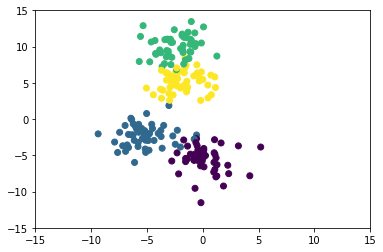

In [2]:
#https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097
# import statements
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

In [3]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
kmeans = KMeans(n_clusters=4)
# fit kmeans object to data
kmeans.fit(points)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(points)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

[[ -2.40167949  10.17352695]
 [ -5.56465793  -2.34988939]
 [ -1.92101646   5.21673484]
 [  0.05161133  -5.35489826]]


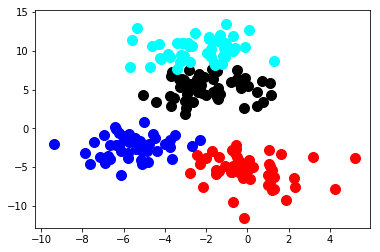

In [4]:
plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='cyan')

# k-means on digits

In [14]:
#https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(1797, 64)

(10, 64)

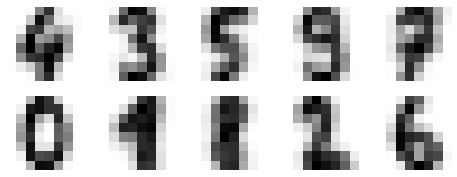

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3));
centers = kmeans.cluster_centers_.reshape(10, 8, 8);
for axi, center in zip(ax.flat, centers):
    _=axi.set(xticks=[], yticks=[]);
    _=axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary);

In [16]:
#Because k-means knows nothing about the identity of the cluster, 
#the 0–9 labels may be permuted. We can fix this by matching each 
#learned cluster label with the true labels found in them
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

0.79354479688369506

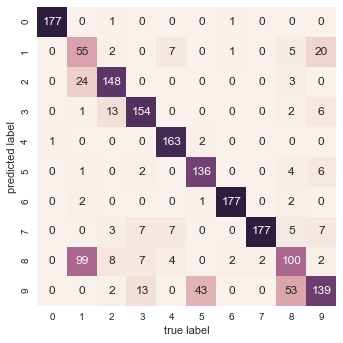

In [17]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
_=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
_=plt.xlabel('true label')
_=plt.ylabel('predicted label');
accuracy_score(digits.target, labels)

We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [9]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.93489148580968284

# Clustering for Color Compression

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

(427, 640, 3)

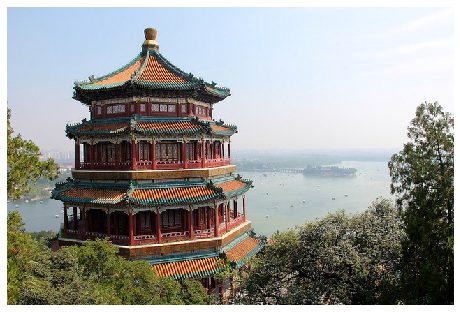

In [18]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);
china.shape

(273280, 3)

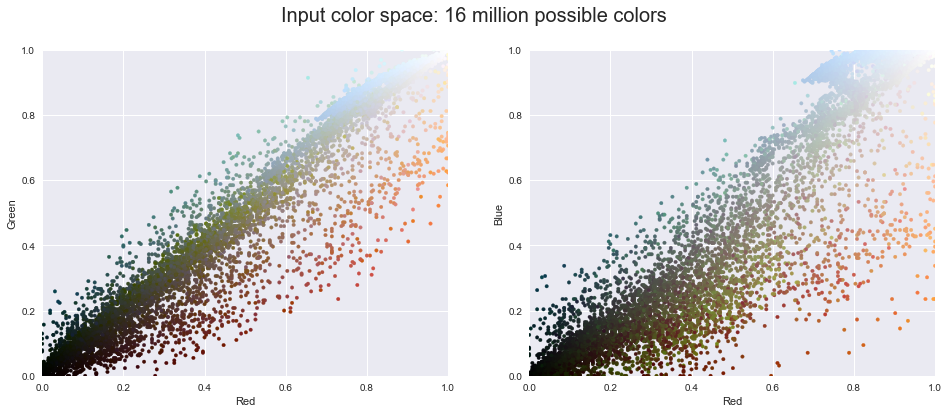

In [19]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=16,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

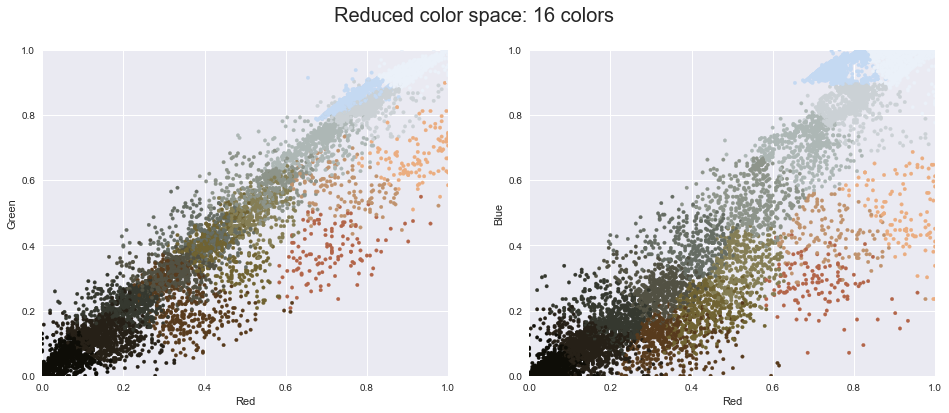

In [20]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
#Read here about MiniBatchKMeans: https://algorithmicthoughts.wordpress.com/2013/07/26/machine-learning-mini-batch-k-means/
#Given: k, mini-batch size b, iterations t, data set X
#Initialize each c ∈ C with an x picked randomly from X
#v ← 0
#for i = 1 to t do
#      M ← b examples picked randomly from X
#      for x ∈ M do
#            d[x] ← f (C, x)           // Cache the center nearest to x
#      end for
#      for x ∈ M do
#            c ← d[x]                    // Get cached center for this x
#            v[c] ← v[c] + 1         // Update per-center counts
#            η ← 1 / v[c]              // Get per-center learning rate
#            c ← (1 − η)c + ηx      // Take gradient step
#      end for
#end for
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this

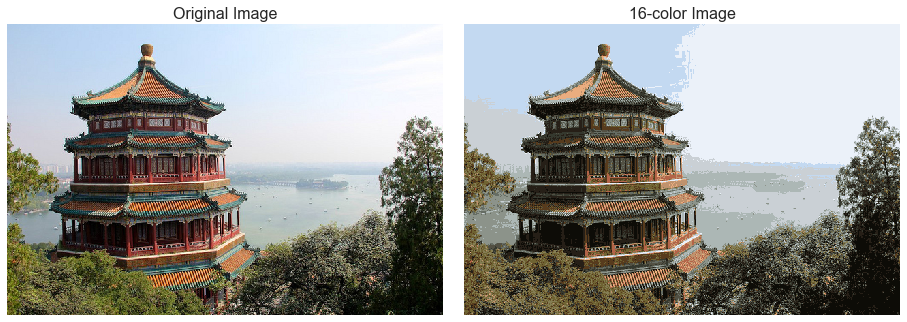

In [21]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! 

# Agglomerative Hierarchical Clustering 

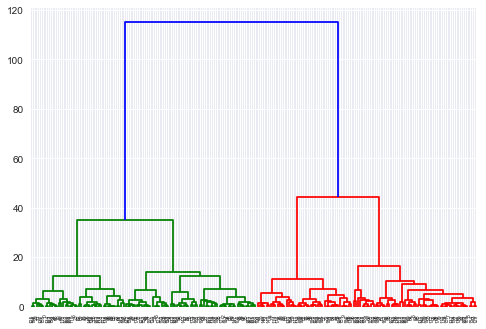

In [24]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(points, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(points)

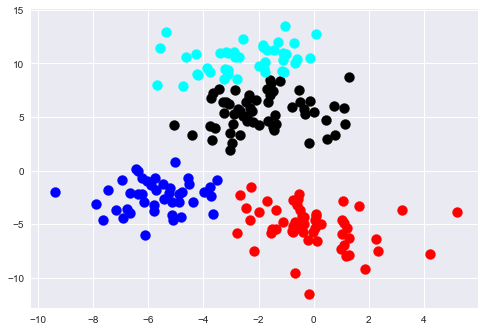

In [23]:
plt.scatter(points[y_hc ==0,0], points[y_hc == 0,1], s=100, c='red')
plt.scatter(points[y_hc==1,0], points[y_hc == 1,1], s=100, c='black')
plt.scatter(points[y_hc ==2,0], points[y_hc == 2,1], s=100, c='blue')
plt.scatter(points[y_hc ==3,0], points[y_hc == 3,1], s=100, c='cyan')